Gen .mat

In [7]:
import os
import glob
import argparse
import pprint
from math import ceil, floor, exp, pi

import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter
from scipy.spatial import KDTree, cKDTree
import xml.etree.ElementTree as ET

In [8]:
# Đường dẫn file XML từ CVAT export
XML_PATH = 'points_annotated/annotations.xml'
# Thư mục xuất file .mat
OUTPUT_MAT = 'points_annotated/mat_gt'
os.makedirs(OUTPUT_MAT, exist_ok=True)

struct_dtype = np.dtype([('locaition', 'O'), ('number', 'O')])

tree = ET.parse(XML_PATH)
root = tree.getroot()

In [23]:
for image in root.iter('image'):
    name = image.attrib['name']
    pts  = []
    for point in image.iter('points'):
        x_str,y_str = point.attrib['points'].split(',')
        pts.append([float(x_str), float(y_str)])
    if not pts: continue

    loc   = np.round(np.array(pts)).astype(np.int32)        # (N,2)
    count = np.array([[len(loc)]], dtype=np.uint8)         # (1,1)

    # 1. Tạo struct instance
    struct_inst = np.array([(loc, count)], dtype=struct_dtype)  # shape=(1,)

    # 2. Bọc vào object-array (1,1)
    inner = np.empty((1,1), dtype=object)
    inner[0,0] = struct_inst

    # 3. Xuất .mat
    savemat(
      os.path.join(OUTPUT_MAT, f"GT_{os.path.splitext(name)[0]}.mat"),
      {'image_info': inner}
    )
    print(f"Saved {name} with {len(loc)} points")

print("Done.")

Saved 8_5_6_pix4d_tile_001.png with 74 points
Saved 8_5_6_pix4d_tile_011.png with 80 points
Saved 8_5_6_pix4d_tile_012.png with 268 points
Saved 8_5_6_pix4d_tile_013.png with 297 points
Saved 8_5_6_pix4d_tile_014.png with 183 points
Saved 8_5_6_pix4d_tile_015.png with 209 points
Saved 8_5_6_pix4d_tile_016.png with 301 points
Saved 8_5_6_pix4d_tile_018.png with 183 points
Saved 8_5_6_pix4d_tile_019.png with 240 points
Saved 8_5_6_pix4d_tile_020.png with 74 points
Saved 8_5_6_pix4d_tile_027.png with 60 points
Saved 8_5_6_pix4d_tile_028.png with 276 points
Saved 8_5_6_pix4d_tile_029.png with 275 points
Saved 8_5_6_pix4d_tile_030.png with 162 points
Saved 8_5_6_pix4d_tile_031.png with 154 points
Saved 8_5_6_pix4d_tile_032.png with 355 points
Saved 8_5_6_pix4d_tile_033.png with 369 points
Saved 8_5_6_pix4d_tile_034.png with 38 points
Saved 8_5_6_pix4d_tile_035.png with 205 points
Saved 8_5_6_pix4d_tile_036.png with 352 points
Saved 8_5_6_pix4d_tile_037.png with 361 points
Saved 8_5_6_pix4d_

In [12]:
data = loadmat('points_annotated/mat_gt/8_5_6_pix4d_tile_001.mat')
pprint.pprint(data)

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Jun 21 '
               b'11:09:50 2025',
 '__version__': '1.0',
 'image_info': array([[array([[(array([[300, 207],
                       [300, 227],
                       [317, 239],
                       [281, 285],
                       [421, 231],
                       [388, 224],
                       [372, 243],
                       [334, 267],
                       [297, 258],
                       [408, 402],
                       [439, 486],
                       [426, 463],
                       [453, 438],
                       [476, 416],
                       [487, 357],
                       [485, 391],
                       [463, 397],
                       [442, 419],
                       [425, 438],
                       [403, 427],
                       [399, 446],
                       [464, 483],
                       [350, 202],
                       [

In [13]:
data = loadmat('datasets/Sample/train_data/ground_truth/GT_IMG_5.mat')
pprint.pprint(data)

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Dec '
               b'19 19:31:19 2022',
 '__version__': '1.0',
 'image_info': array([[array([[(array([[ 406,  441],
                       [ 360,  426],
                       [ 301,  422],
                       [ 242,  344],
                       [ 186,  310],
                       [ 143,  364],
                       [  76,  314],
                       [  79,  259],
                       [ 107,  229],
                       [  98,  194],
                       [  25,  231],
                       [  58,  116],
                       [  21,   91],
                       [  40,   67],
                       [  65,   53],
                       [ 110,   35],
                       [ 193,   10],
                       [ 173,   31],
                       [ 263,   16],
                       [ 250,   61],
                       [ 328,   10],
                       [ 306,   57],
            

Gen .npy

In [14]:
# ## Thiết lập tham số (thay đổi tuỳ bạn)

# %%
img_dir   = 'points_annotated/images'
mat_dir   = 'points_annotated/mat_gt'
output_dir= 'points_annotated/density_maps'
min_size  = 384
max_size  = 512
sigma     = 5

os.makedirs(output_dir, exist_ok=True)

In [15]:
def cal_new_size_v2(im_h, im_w, min_size, max_size):
    rate = 1.0 * max_size / im_h
    rate_w = im_w * rate
    if rate_w > max_size:
        rate = 1.0 * max_size / im_w
    tmp_h = int(1.0 * im_h * rate / 16) * 16
    if tmp_h < min_size:
        rate = 1.0 * min_size / im_h
    tmp_w = int(1.0 * im_w * rate / 16) * 16
    if tmp_w < min_size:
        rate = 1.0 * min_size / im_w
    tmp_h = min(max(int(1.0 * im_h * rate / 16) * 16, min_size), max_size)
    tmp_w = min(max(int(1.0 * im_w * rate / 16) * 16, min_size), max_size)
    rate_h = 1.0 * tmp_h / im_h
    rate_w = 1.0 * tmp_w / im_w
    return tmp_h, tmp_w, rate_h, rate_w

# %% [markdown]
# ## Hàm tạo density map bằng Gaussian

# %%
def gen_density_map_gaussian(im_height, im_width, points, sigma=8):
    density_map = np.zeros([im_height, im_width], dtype=np.float64)
    h, w = im_height, im_width
    pts = np.round(points).astype(int)
    num_gt = pts.shape[0]
    if num_gt == 0:
        return density_map

    # ép radius và ksize thành int để cv2.getGaussianKernel chấp nhận
    radius = int(2 * sigma - 1)
    ksize = 2 * radius + 1
    k = cv2.getGaussianKernel(ksize, sigma)
    kernel = k @ k.T

    for (y, x) in pts:
        y = np.clip(y, 0, h-1)
        x = np.clip(x, 0, w-1)
        y1, y2 = max(0, y-radius), min(h, y+radius+1)
        x1, x2 = max(0, x-radius), min(w, x+radius+1)
        ky1 = radius - (y - y1)
        kx1 = radius - (x - x1)
        subk = kernel[ky1:ky1+(y2-y1), kx1:kx1+(x2-x1)]
        if subk.sum() > 0:
            subk = subk / subk.sum()
        density_map[y1:y2, x1:x2] += subk

    if density_map.sum() > 0:
        density_map *= (num_gt / density_map.sum())
    return density_map

# %% [markdown]
# ## Hàm đọc file `.mat` của bạn

# %%
def parse_mat(mat_path):
    m = loadmat(mat_path)
    info = m['image_info'][0,0]
    # unwrap nếu cần
    if isinstance(info, np.ndarray) and info.dtype == object and info.size>1:
        info = info.reshape(-1)[0]
    loc = info['locaition']
    if isinstance(loc, np.ndarray) and loc.dtype == object:
        loc = loc.reshape(-1)[0]
    return loc.astype(np.float32)  # (N,2)

# %% [markdown]
# ## Hàm chính tạo ảnh, điểm, density map

# %%
def generate_data_kcl(im_path, mat_path, min_size, max_size, sigma):
    im = Image.open(im_path).convert('RGB')
    im_w, im_h = im.size

    points = parse_mat(mat_path)  # (N,2) [x,y]

    new_h, new_w, rh, rw = cal_new_size_v2(im_h, im_w, min_size, max_size)
    im_np = np.array(im)
    if rh!=1.0 or rw!=1.0:
        im_np = cv2.resize(im_np, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        points[:,0] *= rw  # x
        points[:,1] *= rh  # y

    pts_for_dm = np.stack([points[:,1], points[:,0]], axis=1)  # đổi (x,y)->(row,col)
    dm = gen_density_map_gaussian(new_h, new_w, pts_for_dm, sigma=sigma)
    return im_np, points, dm

In [ ]:
# ## Chạy chuyển đổi

# %%
for fname in os.listdir(mat_dir):
    if not fname.endswith('.mat'): continue
    stem = os.path.splitext(fname)[0]
    mat_p = os.path.join(mat_dir, fname)
    img_p = os.path.join(img_dir, stem + '.jpg')
    if not os.path.exists(img_p):
        img_p = os.path.join(img_dir, stem + '.png')
        if not os.path.exists(img_p):
            print(f"⚠️  Không tìm thấy ảnh cho {stem}, bỏ qua")
            continue

    im_np, points, dm = generate_data_kcl(
        img_p, mat_p,
        min_size=min_size,
        max_size=max_size,
        sigma=sigma
    )

    # lưu points
    #pts_out = os.path.join(output_dir, 'GT_' + stem + '.npy')
    #np.save(pts_out, points)
    # lưu densitymap
    dm_out  = os.path.join(output_dir, stem + '_densitymap.npy')
    np.save(dm_out, dm)

    print(f"✅ {stem}: {points.shape[0]} pts, img {im_np.shape[:2]}, dm {dm.shape}")

✅ 8_5_6_pix4d_tile_012: 268 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_016: 301 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_014: 183 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_035: 205 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_030: 162 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_033: 369 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_046: 268 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_047: 168 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_027: 60 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_042: 32 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_011: 80 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_038: 124 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_032: 355 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_048: 357 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_019: 240 pts, img (512, 512), dm (512, 512)
✅ 8_5_6_pix4d_tile_029: 275 pts, img (512, 512), dm (512, 

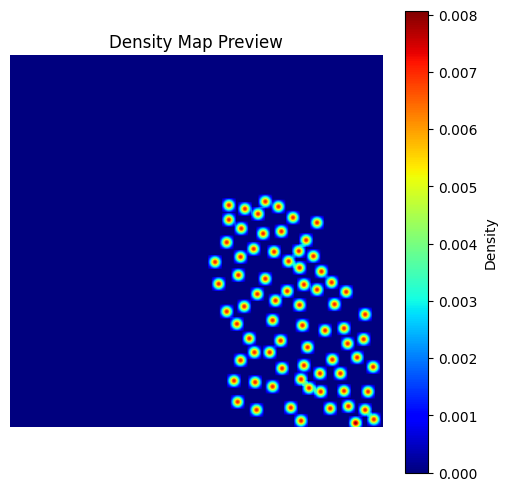

In [17]:
# Load your density map
density_map = np.load('points_annotated/density_maps/8_5_6_pix4d_tile_001_densitymap.npy')

# Display it
plt.figure(figsize=(6,6))
plt.imshow(density_map, cmap='jet')
plt.colorbar(label='Density')
plt.title('Density Map Preview')
plt.axis('off')
plt.show()

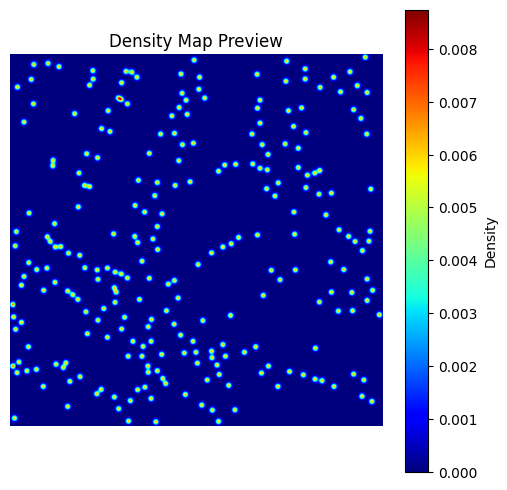

In [18]:
density_map = np.load('datasets/Sample/train_data/ground_truth/IMG_1_densitymap.npy')

# Display it
plt.figure(figsize=(6,6))
plt.imshow(density_map, cmap='jet')
plt.colorbar(label='Density')
plt.title('Density Map Preview')
plt.axis('off')
plt.show()

In [19]:
import numpy as np
dm = np.load('datasets/Sample/train_data/ground_truth/IMG_1_densitymap.npy')
print(dm.shape, dm.dtype, dm.nbytes / 1024 / 1024)


(1024, 1024) float64 8.0
